In [1]:
import argparse
import json
import os
import pathlib
import sys
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import scipy
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cellpose import models
from file_reading import *
from file_reading import read_zstack_image
from general_segmentation_utils import *
from notebook_init_utils import bandicoot_check, init_notebook
from organoid_segmentation import *
from segmentation_decoupling import *
from skimage.filters import sobel

In [2]:
def save_labels(dictionary: dict, outfile: str):
    """
    Description
    ----------
    Save labels to a parquet file.
    Parameters
    ----------
    dictionary : dict
        Dictionary containing labels to save.
    outfile : str
        Path to the output parquet file.
    Returns
    -------
    None

    """

    try:
        pathlib.Path(outfile).parent.mkdir(parents=True, exist_ok=True)
        df = pd.DataFrame(dictionary)
        df.to_parquet(outfile, index=False)
    except Exception as e:
        print(f"Error saving labels to {outfile}: {e}")
        return False
    return True


def read_labels(infile: str) -> dict:
    """
    Description
    ----------
    Read labels from a parquet file.
    Parameters
    ----------
    infile : str
        Path to the input parquet file.
    Returns
    -------
    dict
        Dictionary containing the labels.
    """
    data = pd.read_parquet(infile).to_dict(orient="list")
    return data


def check_for_image_labels(
    dictionary: dict,
    patient: str,
    well_fov: str,
    annotator: str,
) -> bool:
    """
    Description
    ----------
    Check if an image has already been labeled.
    Parameters
    ----------
    dictionary : dict
        Dictionary containing existing labels.
    patient : str
        Patient identifier.
    well_fov : str
        Well FOV identifier.
    annotator : str
        Annotator name.
    Returns
    -------
    bool
        True if the image has been labeled, False otherwise.
    """
    for i in range(len(dictionary["patient"])):
        if (
            dictionary["patient"][i] == patient
            and dictionary["well_fov"][i] == well_fov
        ):
            return True
    return False


def label_images_keypress(
    image_dict: dict, label_map: dict, labels_save_file: pathlib.Path
) -> dict:
    """
    Label images using keyboard input.

    Parameters
    ----------
    image_paths : list of str
    label_map : dict
        Mapping from key press (str) to label value

    Returns
    -------
    dict
    """
    annotator = input("Enter annotator name: ")

    labels = {"patient": [], "well_fov": [], "label": [], "annotator": []}
    if labels_save_file.exists():
        labels = read_labels(labels_save_file)
    for i, image_path in enumerate(image_dict["image_path"]):
        if check_for_image_labels(
            dictionary=labels,
            patient=image_dict["patient"][i],
            well_fov=image_dict["well_fov"][i],
            annotator=annotator,
        ):
            continue
        image = read_zstack_image(image_path)
        # load the middle slice to check if there is anything there
        mid_slice = image.shape[0] // 4
        image_mid = image[mid_slice, :, :]
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(image_mid, cmap="inferno")
        ax.axis("off")
        plt.show(block=False)
        key = input("Press key for label: ")
        plt.close(fig)
        labels["annotator"].append(annotator)
        labels["patient"].append(image_dict["patient"][i])
        labels["well_fov"].append(image_dict["well_fov"][i])
        labels["label"].append(label_map.get(key, None))
        save_labels(labels, labels_save_file)

    return labels

In [3]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [4]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)
patient_list_file_path = pathlib.Path(f"{root_dir}/data/patient_IDs.txt").resolve(
    strict=True
)

In [5]:
labels_save_file = pathlib.Path(
    "../image_labels/organoid_image_labels.parquet"
).resolve()
labels_save_file_bandicoot = pathlib.Path(
    f"{image_base_dir}/data/organoid_image_labels/organoid_image_labels.parquet"
).resolve()
labels_save_file.parent.mkdir(exist_ok=True, parents=True)

In [6]:
patients = pd.read_csv(patient_list_file_path, header=None)[0].tolist()
images_to_process = {"patient": [], "well_fov": [], "image_path": []}

for patient_id in tqdm.tqdm(patients):
    input_subparent_name = "zstack_images"
    image_dir = pathlib.Path(
        f"{image_base_dir}/data/{patient_id}/{input_subparent_name}"
    )
    well_fovs = sorted([d for d in image_dir.iterdir() if d.is_dir()])
    for well_fov_path in well_fovs:
        well_fov = well_fov_path.name

        images_to_process["patient"].append(patient_id)
        images_to_process["well_fov"].append(well_fov)
        images_to_process["image_path"].append(
            pathlib.Path(f"{image_dir}/{well_fov}/{well_fov}_555.tif")
        )

df = pd.DataFrame(images_to_process)
print(f"Images to process: {len(df)}")
df.head()

100%|██████████| 12/12 [00:00<00:00, 55.91it/s]

Images to process: 3720


patient well_fov                                         image_path
0  NF0014_T1    C10-1  /home/lippincm/mnt/bandicoot/NF1_organoid_data...
1  NF0014_T1    C10-2  /home/lippincm/mnt/bandicoot/NF1_organoid_data...
2  NF0014_T1    C11-1  /home/lippincm/mnt/bandicoot/NF1_organoid_data...
3  NF0014_T1    C11-2  /home/lippincm/mnt/bandicoot/NF1_organoid_data...
4  NF0014_T1     C2-1  /home/lippincm/mnt/bandicoot/NF1_organoid_data...

In [7]:
label_map = {"1": "globular", "2": "dissociated", "3": "small", "4": "elongated"}

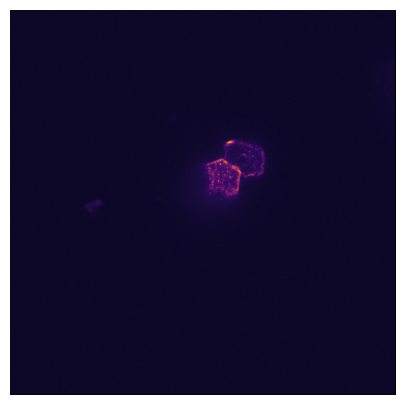

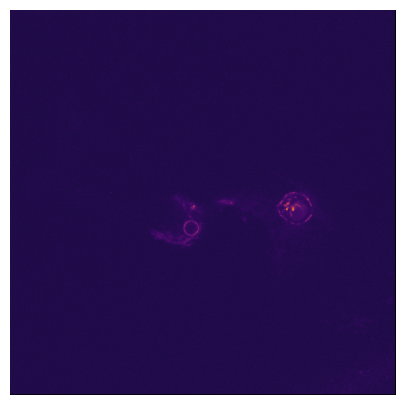

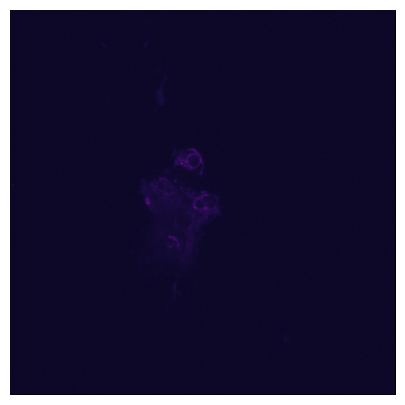

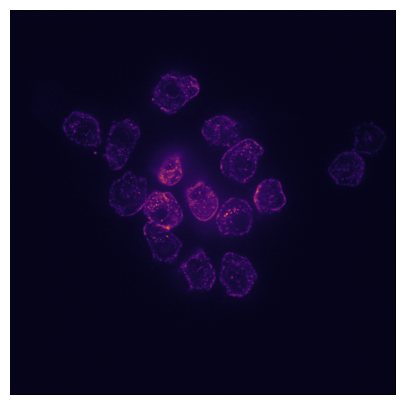

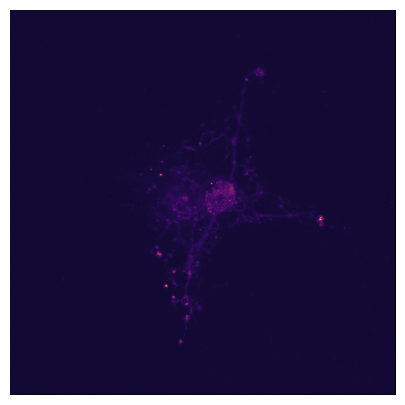

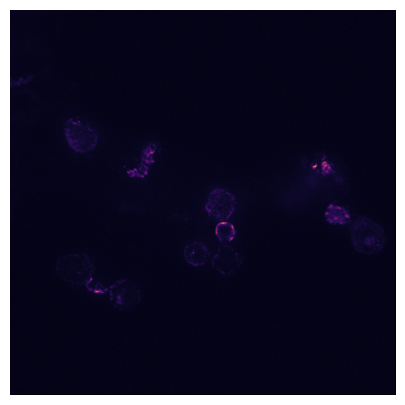

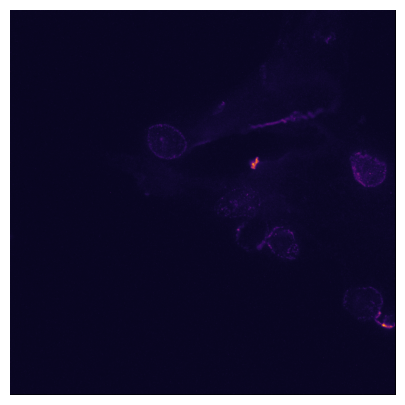

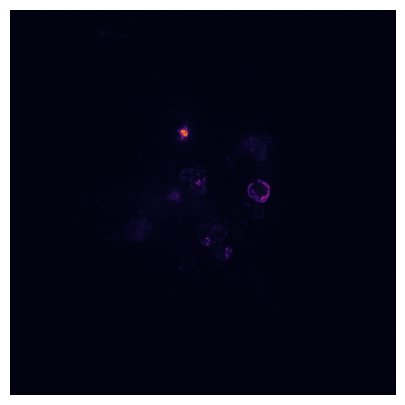

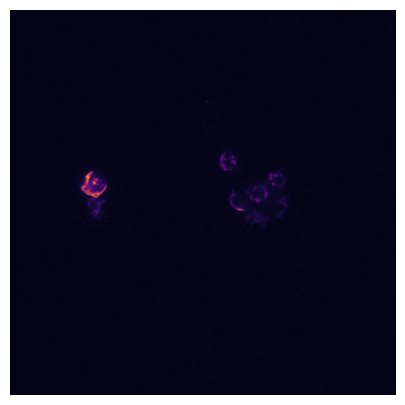

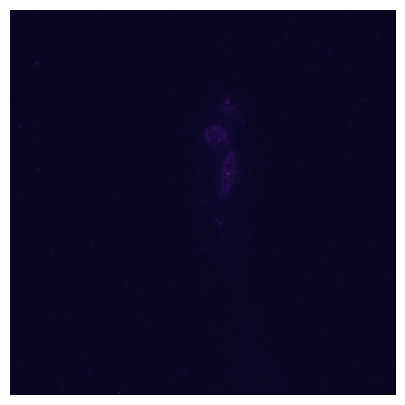

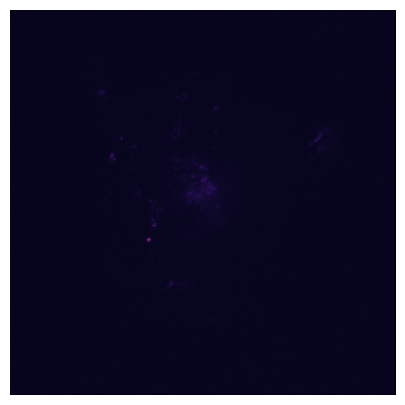

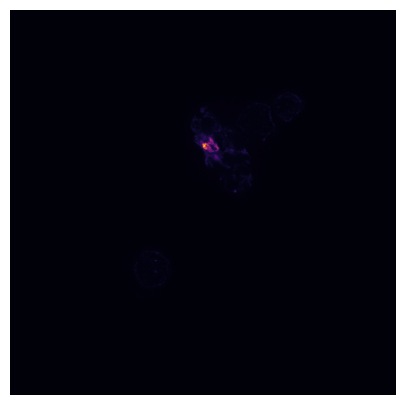

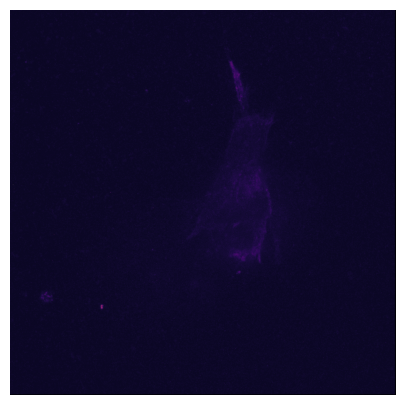

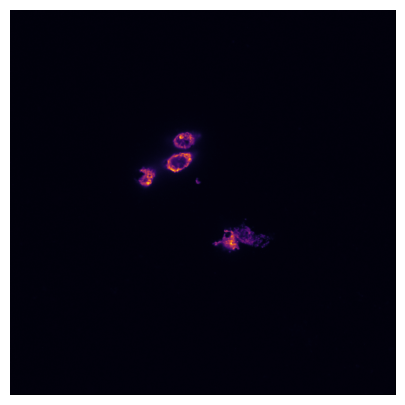

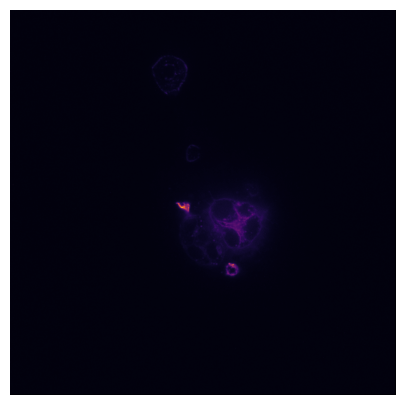

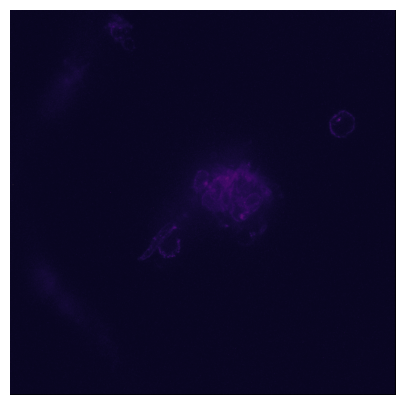

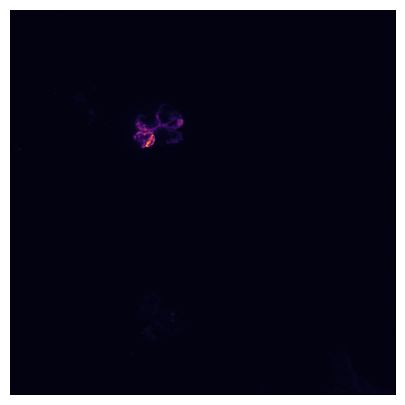

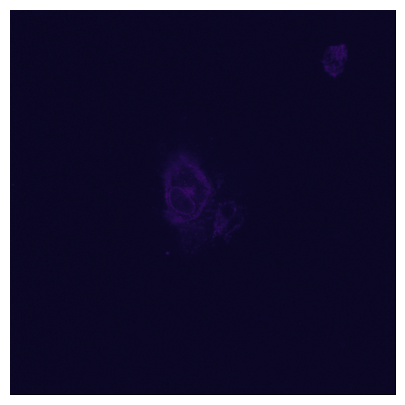

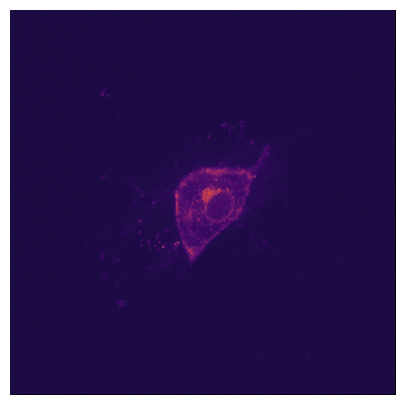

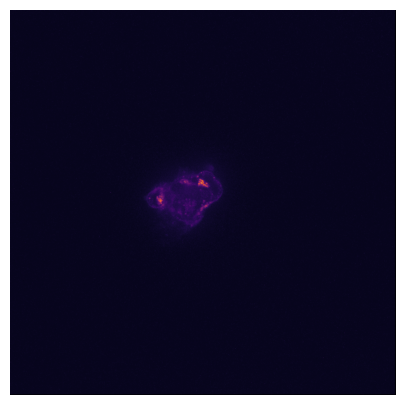

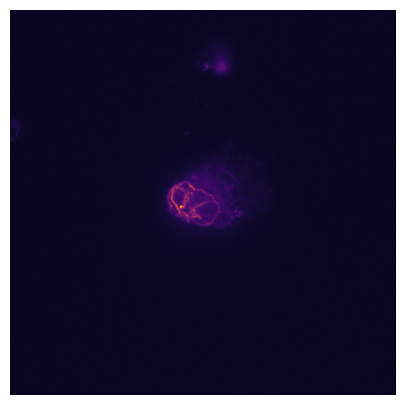

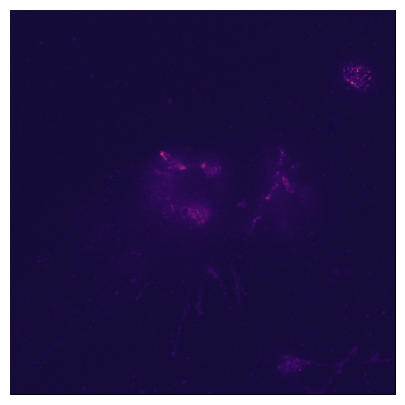

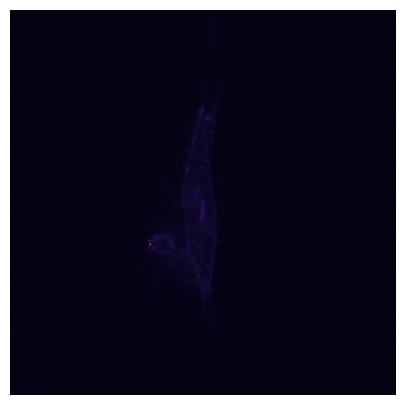

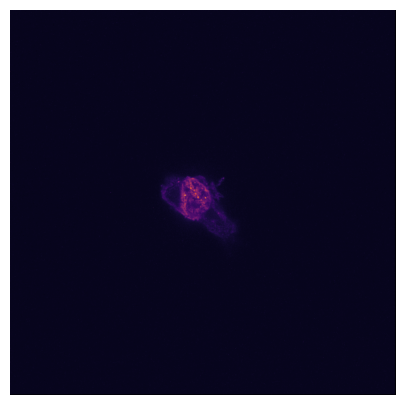

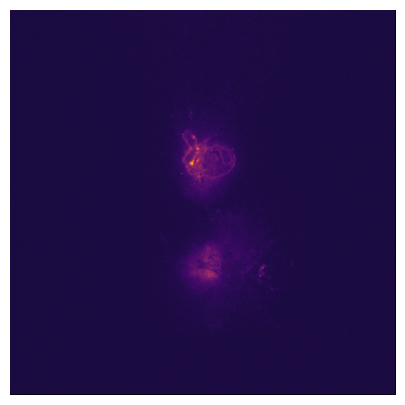

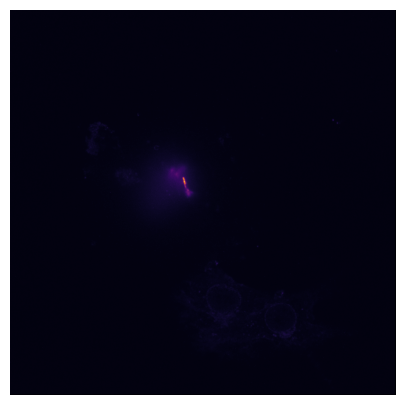

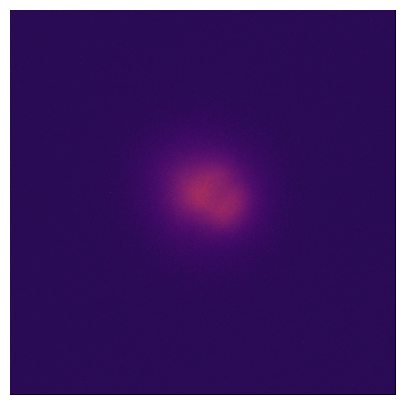

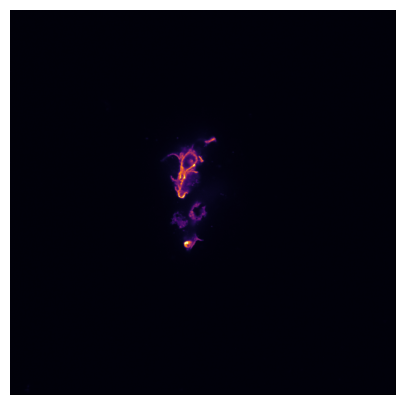

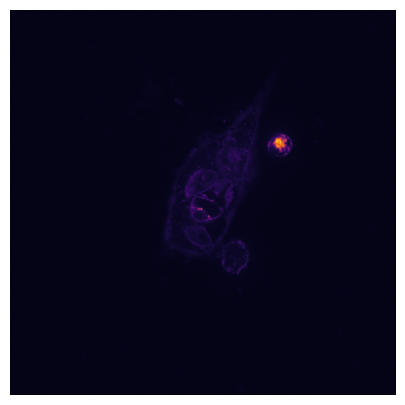

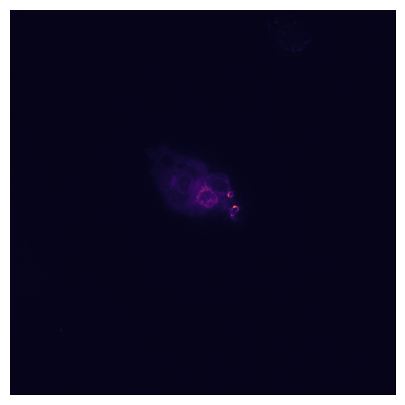

In [ ]:
labels = label_images_keypress(images_to_process, label_map, labels_save_file)
save_labels(labels, labels_save_file_bandicoot)

In [ ]:
labels = read_labels(labels_save_file)
# show stats for the labeling
df = pd.DataFrame(labels)
print("Label counts:")
print(df["label"].value_counts())
# print a list of well fovs for each label
for label in label_map.values():
    well_fovs = df[df["label"] == label][["patient", "well_fov"]]
    print(f"\nWell FOVs for label '{label}':")
    counter = 0
    for index, row in well_fovs.iterrows():
        if counter >= 10:
            break
        print(f"{row['well_fov']}")
        counter += 1